In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.model_selection
import sklearn.linear_model

np.random.seed(0)

<img src="https://i.stack.imgur.com/T7wwy.png" width=700>

# Part 1

# 1. Constructing confidence intervals via central limit theorem

In [2]:
# Paper: https://www-nature-com.proxy1.lib.uwo.ca/articles/s41380-019-0496-z
# Article: https://www.scientificamerican.com/article/a-blood-test-might-one-day-mass-screen-military-personnel-for-ptsd/

# Let's construct CIs on the test error of the results from this article/paper above. Here we have 42 correct predictions
# out of 52 total predictions in our test set. This is put into a csv file called tpr.csv (stands for "test predictions").

tdf = pd.read_csv("tpr.csv")
#display(tdf)

# The test claims to be 81% effective. How confident can we be in these test results? We'll now construct CIs.

In [3]:
# Using Central Limit Theorem (CLT), compute Confidence Intervals (CI) (use ddof=1 to indicate we're using the sample mean)
std_err = np.std(tdf.C, ddof=1)/np.sqrt(len(tdf))

ci = [tdf.C.mean() - 1.96*std_err, tdf.C.mean() + 1.96 * std_err]
print(ci)

[0.6995259303231, 0.9158586850615155]


# 2. Constructing confidence intervals via bootstrap

In [4]:
# Let's now compute a CI with 10000 bootstrap samples and get the means, given a sample S (dataframe)

def bootstrap(S):
    num_iterations = 1000
    sample_size = len(S)
    
    #initialize empty array of bootstrap means
    boot_means = np.zeros(1000)
    
    for i in range(num_iterations):
        boot_means[i] = S.sample(sample_size, replace=True).mean()
    
    return boot_means

C:\Users\jacob\miniconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

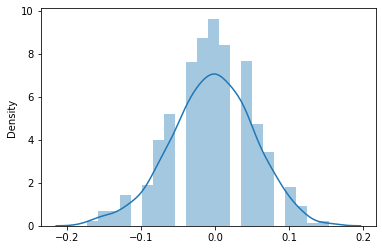

In [5]:
# Plot histogram centered around the sample mean
sns.distplot(bootstrap(tdf)-tdf.C.mean())

In [6]:
# Compute quantiles (i.e. 2.5% and 97.5% quantiles for 95% CI)
q = np.quantile(bootstrap(tdf)-tdf.C.mean(), [0.025, 0.975])
print(q)

[-0.11538462  0.09615385]


In [7]:
# Compute confidence interval
bci = [tdf.C.mean() - q[1],tdf.C.mean() - q[0]]
print(bci)

[0.7115384615384616, 0.9230769230769231]


# Part 2

# 1. Building a linear model

In [8]:
# Data: 1000 North Carolina births. Let's consider weeks (length of the pregnancy) and weight (birth weight in pounds).
bdf = pd.read_csv("ncb.csv")
#display(bdf)

In [9]:
# Important trick: Let's exclude observations with missing week or weight data (NaN values). 
bdf = bdf.dropna(subset=["weeks","weight"])

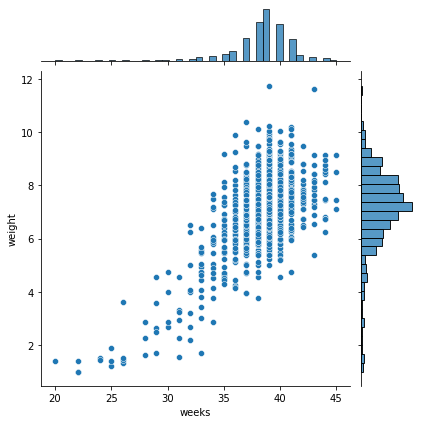

In [10]:
# What does the joint distribution look like?
sns.jointplot(data=bdf, x='weeks', y='weight')

In [11]:
# Let's build a linear model (w.r.t. b's.. consider a function form of b0x + b1x^2 + b2x^3) on this data and plot the fit 

# create sklearn LinearRegression() object
reg = sklearn.linear_model.LinearRegression()

# create design matrix (i.e. the X matrix)
X = np.c_[bdf.weeks, bdf.weeks**2, bdf.weeks**3]

# using linear regression, fit the data
reg.fit(X, bdf.weight)
print(reg.coef_)

[-5.21866875e+00  1.78832738e-01 -1.85596626e-03]


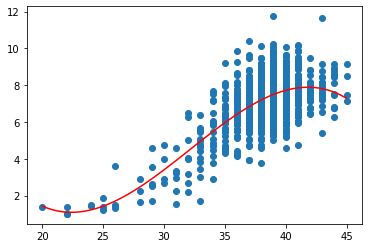

In [12]:
# Ok, now that we have a parameter estimate we can plot a curve of best fit to the data (from our linear regression)

# generate many x points for a smooth curve fit
x_new = np.linspace(min(bdf.weeks), max(bdf.weeks),100)

# create design matrix (i.e. the X matrix)
X_new = np.c_[x_new, x_new**2, x_new**3]

# generate our curve of best fit predictions, given X_new
ypr = reg.predict(X_new)

# plot the dat and the curve of best fit
plt.scatter(bdf.weeks, bdf.weight)
plt.plot(x_new, ypr, color="red")

## 2. Bootstrap the model parameters

In [13]:
# Let's bootstrap the model parameters b1,b2,b3 with 10000 bootstrap samples, given a sample S (dataframe)
def bootstrap_param(S):
    num_iterations = 1000
    sample_size = len(S)
    
    #initialize empty array of bootstrap parameter estimates
    boot_thetas = np.zeros((1000,3))
    
    for i in range(num_iterations):
        # create bootstrap sample
        S_star = S.sample(sample_size, replace=True)
        
        # create design matrix from bootstrap sample
        X = np.c_[S_star.weeks, S_star.weeks**2, S_star.weeks**3]
        reg.fit(X,S_star.weight)
        boot_thetas[i,:] = reg.coef_ 
    return boot_thetas

In [14]:
# We can call the function and see our bootstrapped sets of parameter estimates
boot_thetas = bootstrap_param(bdf)
print(boot_thetas)

[[-4.81552861e+00  1.66390004e-01 -1.73211727e-03]
 [-4.54708090e+00  1.55138873e-01 -1.59135590e-03]
 [-5.26741945e+00  1.79189875e-01 -1.84776760e-03]
 ...
 [-6.70186679e+00  2.25312805e-01 -2.33102731e-03]
 [-5.75909675e+00  1.96940596e-01 -2.05045950e-03]
 [-5.30911348e+00  1.83295222e-01 -1.91545680e-03]]


## 3. Bootstrap the model prediction

In [15]:
# Finally, let's bootstrap the model prediction with 10000 bootstrap samples, given a sample S (dataframe) and x values
def bootstrap_pred(S):
    num_iterations = 1000
    sample_size = len(S)

    # Let's create our x data using linspace to get a smooth plot for each bootstrap-predicted set of y values
    x_new = np.linspace(min(S.weeks),max(S.weeks),100)
    X_new = np.c_[x_new,x_new**2,x_new**3]
    
    # Let's also initialize our ypred to an array of 0's
    ypred = np.zeros((1000,X_new.shape[0]))
    
    for i in range(num_iterations):
        #Here we want to store predictions for y from bootstrapped samples. Within the loop, let's get each sample S_star.
        S_star = S.sample(num_iterations,replace=True)
        
        #create design matrix from bootstrapped sample, fit to data
        X = np.c_[S_star.weeks, S_star.weeks**2, S_star.weeks**3]
        reg.fit(X,S_star.weight)
        
        #store predictions for y in ypred array
        ypred[i,:] = reg.predict(X_new)
    return ypred

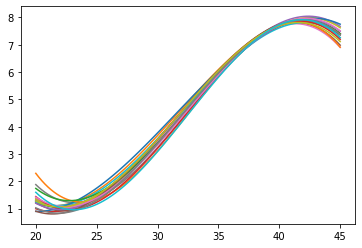

In [16]:
# Plot 20 of the bootstrapped predictions 
ypr_boot = bootstrap_pred(bdf)

for i in range(20):
    plt.plot(x_new, ypr_boot[i,:])

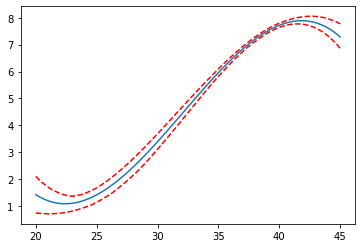

In [17]:
# Finally, let's compute our upper and lower bounds of our confidence interval for the predictions 
lower = np.quantile(ypr_boot - ypr, 0.025, axis=0) #axis=0 refers to rows
upper = np.quantile(ypr_boot - ypr, 0.975, axis=0)

#plot prediction
plt.plot(x_new, ypr)
#plot confidence interval (from bootstrap)
plt.plot(x_new, ypr - upper, 'r--')
plt.plot(x_new, ypr - lower, 'r--')
